# Explanation of the following mess:

## Data analysis and pre processing

Variables were selected based on "economics" intuition. This means, what are the drivers of choices of people. Some of these variables (although not an exhaustive list) are: income, municipality of residency, main occupation, etc. individuals with missing values were dropped. I am aware of the loss of information implied in this, however, the model is already complex and modeling the missing values would be an unnecessary added complexity. 

## Model

As exposed on the previous milestone, the model I am working in is a state space model where the hidden state depends on both previous hidden states, socio-economic factors and spatio-temporal factors. In this milestone, these relations are lineal, however, in future work it would be ideal to have non-linearities between these variables. The hidden state size is a hyperparameter we have to fix before the estimation. The hidden state, is useful for different classification and regression tasks. Using the hidden-state I will predict the activity of the person, the location of the activity, the mode chosen and the dwell time. All these tasks have to be worked out with a non so highly dimensional hidden state. 

Furthermore, it would be interesting to see these hidden states on a low dimension plot, intuition would say that these are some form of probabilistic embeddings and they can convey even further information of the individuals in the dataset. 

### Implementation challanges

Even though the model is completely programmed, there are some bugs in it. The last one I have detected which I havent corrected are the integers used for the categorical logit. They have to be ordered and cannot take arbitrary values as they come on the dataset, I will work on that during this week and hopefully would be able to run the model during the weekend. 

## Next steps

Some interesting directions in which I can take this model are:
- The implementation of non-linearities on the relations between variables and hidden-state
- The implementation of the dwell time as a mixture of distributions
- The implementation of missing values imputation

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import pystan
import pystan_utils
import scipy.special # For the softmax function

# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Pandas options
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 150)

# Data loading and pre-processing

For this project we are ussing two datasets: the sessions data set which contains socio-economic and travel related data of people and the trip data set which contains a travel diary for a person for a day, including information related to the trip purpose, mode choice, etc.

The following tasks are done in the next section:
- [x] Load the trip (tur.csv) data set
- [x] Pick relevant features for the trip data set

- [x] Load the session (session.csv) data set
- [x] Pick relevant features from the session data set
- [x] Sample a small fraction (5%) of the total data set using 42 as a seed for speed and replication purposes

- [x] Subset both data sets using the picked relevant features
- [x] 

In [4]:
# Data path
data_path = '/mnt/sdb1/data_shgm/TU0616_csv/'

In [5]:
# Trips data which is going to be merged with the session dataset
trip_df = pd.read_csv(os.path.join(data_path, 'tur.csv'))

In [6]:
trip_df.shape # (429371, 74)

(429371, 74)

In [7]:
trip_df.head()

,TurId,SessionId,TurNr,TripCount,DepartHH,DepartMM,DepartMSM,ArrivalHH,ArrivalMM,ArrivalMSM,DestDwelTime,OrigNUTS,OrigMuncode,OrigOldMuncode,OrigCityCode,OrigNTMzone,OrigNearestStation,OrigDistNearestStation,DestNUTS,DestMuncode,DestOldMuncode,DestCityCode,DestNTMzone,DestNearestStation,DestDistNearestStation,OrigPurp,DestPurp,DestEscortPurp,TripPurp,TripPurpGroup,SimplWorktour,SimplWorkNumstop,GISdist,NumModes,SumLen,SumMin,SumMotorLen,SumMotorMin,ModeChainType,PrimMode,PrimModeDrivPass,SecMode,PrimModeSumlen,SecModeSumlen,FirstMode,LastMode,PartyorAlone,PartyNumu10,PartyNum1017,PartyNumAdults,BicType,CarPassDriver,CarPassContext,CarUsageCarNo,PtTicketType,PtPrice,PtBicType,PtPrimMode,PtAccMode,PtEgrMode,PtAccLen,PtEgrLen,FirstStation,LastStation,TrainMode,TrainAccMode,TrainEgrMode,TrainAccLen,TrainEgrLen,TrainAccDist,TrainEgrDist,JourneyId,JourneyRole,GISdistJourneyStartP
0,47,50026,1,1.0,9.0,30.0,570.0,10.0,25.0,625.0,605.0,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,1.0,41.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,1.0,50.8
1,48,50026,2,1.0,20.0,30.0,1230.0,21.0,25.0,1285.0,NaN,DK041,779.0,779.0,10791.0,779142.0,Skive ...,3.6,DK041,657.0,657.0,11007.0,657133.0,Herning ...,1.1,41.0,1.0,NaN,41,40,2,NaN,50.79,1.0,55.0,55.0,55.0,55.0,11.0,11.0,1.0,NaN,55.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0.0,0.0
2,49,50027,1,1.0,9.0,5.0,545.0,9.0,10.0,550.0,20.0,DK041,779.0,779.0,10791.0,779154.0,Skive ...,3.3,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,1.0,41.0,NaN,41,40,2,NaN,2.20,1.0,2.0,5.0,2.0,5.0,11.0,11.0,1.0,NaN,2.0,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,21.0,2.2
3,50,50027,2,1.0,9.0,30.0,570.0,9.0,40.0,580.0,35.0,DK041,779.0,779.0,10791.0,779152.0,Skive ...,1.1,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,41.0,31.0,NaN,31,30,2,NaN,2.12,1.0,3.5,10.0,3.5,10.0,11.0,11.0,1.0,NaN,3.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,1.0,2.6
4,51,50027,3,1.0,10.0,15.0,615.0,10.0,25.0,625.0,0.0,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.8,DK041,779.0,779.0,10791.0,779141.0,Skive ...,2.1,31.0,49.0,NaN,31,30,2,NaN,1.30,1.0,2.5,10.0,2.5,10.0,11.0,11.0,1.0,NaN,2.5,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,NaN,3.5


In [8]:
# The variables of interest from the tur dataset are:
trip_vars = [
    'SessionId',
    'TurNr',
    'PrimMode',
    'DepartMSM', 
    'OrigMuncode',
    'DestMuncode',
    'TripPurpGroup',
    'DestDwelTime'
]

In [9]:
# Subsetting of the trip data set using the variables chosen before 
trip_df  = trip_df[trip_vars]

In [10]:
# Socioeconomic dataset which is merged with the trips data, the datasets are merged using the 'SessionID' variable where the 
#  socioeconomic variables are repeated across trips
socio_df = pd.read_csv(os.path.join(data_path, 'session.csv'))

In [11]:
## The variables of interest from the session dataset are:
#   I picked these variables using pure "economic" and "transport" intuition. 
#   In the exploratory data analysis I am going to check whether this intuition solves anything
socio_vars = [
    'SessionId',
    'DiaryMonth',
    'DiaryWeekday',
    'DiaryDaytype',
    'HomeAdrMunCode',
    'RespSex',
    'RespAgeCorrect',
    'RespMainOccup',
    'RespEdulevel',
    'PrimOccMuncode',
    'RespHasBicycle',
    'RespHasSeasonticket',
    'HousehCarOwnership',
    'IncRespondent2000',
    'FamNumPers',
    'FamNumAdults', # To know if they have kids
]

In [12]:
# For speed in the training process, we use only a small fraction of the total population
socio_df = socio_df.sample(frac=0.05, random_state=42) 

In [13]:
socio_df['kids'] = socio_df.FamNumPers-socio_df.FamNumAdults
socio_df.head()

,SessionId,InterviewType,DiaryDate,DiaryYear,PseudoYear,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrNUTS,HomeAdrMunCode,HomeAdrOldMuncode,HomeAdrCityCode,HomeAdrCitySize,HomeAdrNTMzone,HomeAdrNearestStation,HomeAdrDistNearestStation,HomeParkPoss,RespSex,RespYearBorn,RespAgeSimple,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,PrimOccOldMuncode,PrimOccNTMzone,WorkHoursPw,WorkHourType,WorkPubPriv,WorkatHomeDayspM,SduMuncode,SduOldMuncode,SduNTMzone,GISdistHW,kmarbud,HwDayspW,HwDaysReason,WorkParkPoss,RespHasBicycle,RespHasSeasonticket,RespHasRejsekort,ResphasDrivlic,RespDrivlicYear,RespIsmemCarshare,HousehNumcars,HousehCarOwnership,Handicap,HousehAccomodation,HousehAccOwnorRent,IncRespondent,IncRespondent2000,IncSpouse,IncSpouse2000,IncNuclFamily,IncNuclFamily2000,IncFamily,IncFamily2000,IncHouseh,IncHouseh2000,NuclFamType,PosInFamily,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumDrivLic,DayStartNUTS,DayStartMuncode,DayStartOldMuncode,DayStartCityCode,DayStartNTMzone,DayStartJourneyRole,DayStartPurp,RespNotripReason,NightsAway,TotalNumTrips,NumTripsCorr,NumTripsExclComTrans,TotalLen,TotalLenExclComTrans,TotalMotorLen,TotalBicLen,TotalMin,TotalMotorMin,PrimModeDay,ModeChainTypeDay,DayNumJourneys,JstartType,JstartMuncode,JstartNTMzone,JstartNearestStation,JstartDistNearestStation,DayJourneyType,DayPrimTargetMuncode,DayPrimTargetPurp,SessionWeight,kids
11832,113294,2,13606,2007,2006/7,4,2,13,DK041,657,657.0,11077.0,3847.0,657213.0,Herning ...,8.0,NaN,2,1941,66,65,10.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,1.0,1959.0,2.0,1.0,1.0,2.0,1.0,1.0,100.0,87.0,150.0,131.0,250.0,218.0,250.0,218.0,250.0,218.0,20.0,11.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,DK041,657.0,657.0,11077.0,657213.0,0.0,1.0,NaN,NaN,2,2,2,230.00,230.00,230.0,0.0,276,276,11.0,11.0,1.0,2.0,657.0,657213.0,Herning ...,8.0,11,707.0,44.0,455.506948,0.0
15572,117572,2,13708,2007,2007/8,7,6,23,DK032,573,573.0,0.0,NaN,573125.0,Sig ...,4.1,NaN,1,1955,52,51,30.0,11.0,561.0,561.0,561142.0,56.0,NaN,1.0,0.0,573.0,573.0,573125.0,23.2,10.0,5.0,NaN,11.0,1.0,2,NaN,1.0,1975.0,2.0,2.0,2.0,2.0,1.0,1.0,550.0,482.0,NaN,NaN,550.0,482.0,550.0,482.0,550.0,482.0,21.0,12.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,DK032,573.0,573.0,0.0,573125.0,0.0,1.0,NaN,NaN,4,4,4,58.00,58.00,58.0,0.0,72,72,11.0,11.0,2.0,2.0,573.0,573125.0,Sig ...,4.1,11,561.0,11.0,369.105117,1.0
128334,340786,2,16565,2015,2015/16,5,7,32,DK032,540,523.0,10941.0,406.0,540335.0,Sønderborg ...,16.1,4.0,1,1982,33,33,30.0,11.0,540.0,523.0,540322.0,37.0,1.0,1.0,0.0,540.0,523.0,540335.0,7.3,NaN,5.0,NaN,11.0,1.0,2,NaN,1.0,2000.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,11.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,DK032,540.0,523.0,10941.0,540335.0,0.0,1.0,NaN,NaN,2,2,2,44.00,44.00,44.0,0.0,60,60,11.0,11.0,1.0,2.0,540.0,540335.0,Sønderborg ...,16.1,11,540.0,43.0,391.903621,1.0
97395,300923,0,15363,2012,2011/12,1,2,11,DK013,219,219.0,10808.0,1364.0,219031.0,Hillerød ...,2.8,NaN,2,1997,15,14,1.0,2.0,219.0,219.0,219062.0,NaN,NaN,NaN,NaN,219.0,219.0,219031.0,3.7,NaN,5.0,NaN,11.0,1.0,2,NaN,-18.0,NaN,NaN,2.0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,DK013,219.0,219.0,10808.0,219031.0,0.0,1.0,NaN,NaN,5,5,5,11.89,11.89,9.5,1.0,44,20,31.0,132.0,2.0,2.0,219.0,219031.0,Hillerød ...,2.8,11,219.0,12.0,239.691289,1.0
88423,203173,2,15112,2011,2011/12,5,3,11,DK042,746,737.0,10435.0,5553.0,746033.0,Ry ...,0.7,NaN,2,1995,16,15,1.0,2.0,746.0,737.0,746033.0,NaN,NaN,NaN,NaN,746.0,737.0,746033.0,0.5,NaN,5.0,NaN,11.0,1.0,2,NaN,-18.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,20.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,2.0,DK042,746.0,737.0,10435.0,746033.0,0.0,1.0,NaN,NaN,4,4,4,2.00,2.00,1.0,1.0,8,4,11.0,21.0,2.0,2.0,746.0,746

In [14]:
# Create the kids variable
# Does the family have kids?
socio_df['kids'] = socio_df.FamNumPers-socio_df.FamNumAdults

socio_df = socio_df[socio_vars]

# Drop the (now) redundant variables
socio_df = socio_df.drop(['FamNumPers', 'FamNumAdults'], axis=1)

# Drop nans in the socio dataset after subsetting the variables. A more elegant approach would be to assume a distribution on the variables with missing values. This is left to future work
socio_df = socio_df.dropna()

# Turn variables into int type
socio_df = socio_df.astype('int')

In [15]:
# Merge the data set
df = trip_df.merge(socio_df, how='left', on='SessionId')

In [16]:
# Gets the list of session ids which have null values in any variable different from destdweltime (since all ids have nan there)
drop_idx = list(set(df.SessionId[df[set(df)-set(['DestDwelTime'])].isnull().any(axis=1)])) 
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0])).reset_index(drop=True)

In [17]:
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]
# Gets the list of session ids which have a value of 1 on the max number of trips since we are interested in modeling sequences
drop_idx = list(N_trips.SessionId[N_trips.TurNr==1])
df = df.drop(pd.Index(np.where(df['SessionId'].isin(drop_idx))[0]))
N_trips = df.groupby('SessionId').max().reset_index()[['SessionId', 'TurNr']]

In [18]:
# We sort the values by session id and trip number and we extract the indices of them
df.sort_values(by=['SessionId', 'TurNr'], inplace=True)
N_trips.sort_values(by='SessionId', inplace=True)
trip_idx = N_trips['TurNr'].cumsum()

In [19]:
df[list(set(df)-set(['DestDwelTime']))] = df[list(set(df)-set(['DestDwelTime']))].astype('int')

In [20]:
# Different parametrization of time so we make sure that 11:59pm is close to 12:00am
df['HH_1'] = np.sin(2*np.pi*(df.DepartMSM-180)/1440)
df['HH_2'] = np.cos(2*np.pi*(df.DepartMSM-180)/1440)

# Drop redundant variables
df = df.drop(['DepartMSM'], axis=1)

In [21]:
df.describe()
# RespHasSeasonticket 1 yes
# RespHasBicycle      1 yes 
# RespEdulevel        1-5 high school, 6-12 vocational 13- upper education
# RespMainOccup       1-3 student, 22 30 50 52 employeed, 10 11 20 12 15 out of workforce
# DiaryDaytype        11 Mon-Thur, 12 23 32 Fri-Sun, 13 33 Holiday

,SessionId,TurNr,PrimMode,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,DiaryDaytype,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,HH_1,HH_2
count,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,9203.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,12525.000000,1.252500e+04
mean,200641.012455,2.905230,9.123034,481.223872,481.266747,28.116647,163.573509,6.516168,3.765908,15.554172,482.876567,1.508104,37.339082,23.825150,9.160639,477.416048,1.204950,1.865469,1.137006,240.640719,0.106364,-4.461422e-01
std,87958.638920,1.987234,7.367576,255.952667,256.174282,12.407932,181.282564,3.449434,1.973791,7.599529,253.762771,0.499954,15.544737,13.836007,4.643338,261.081076,0.403681,0.341235,0.730047,195.073447,0.688130,5.623029e-01
min,50027.000000,1.000000,1.000000,101.000000,101.000000,11.000000,0.000000,1.000000,1.000000,11.000000,101.000000,1.000000,7.000000,1.000000,1.000000,101.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00
25%,138919.000000,1.000000,2.000000,230.000000,230.000000,12.000000,17.000000,3.000000,2.000000,11.000000,240.000000,1.000000,25.000000,3.000000,5.000000,210.000000,1.000000,2.000000,1.000000,118.000000,-0.500000,-9.396926e-01
50%,176893.000000,2.000000,11.000000,479.000000,479.000000,30.000000,86.000000,6.000000,4.000000,11.000000,479.000000,2.000000,39.000000,30.000000,11.000000,479.000000,1.000000,2.000000,1.000000,244.000000,0.130526,-7.071068e-01
75%,304785.000000,4.000000,11.000000,741.000000,741.000000,40.000000,273.500000,10.000000,5.000000,23.000000,740.000000,2.000000,50.000000,30.000000,13.000000,746.000000,1.000000,2.000000,2.000000,317.000000,0.831470,6.123234e-17
max,359787.000000,21.000000,51.000000,997.000000,997.000000,50.000000,1050.000000,12.000000,7.000000,33.000000,860.000000,2.000000,82.000000,52.000000,14.000000,999.000000,2.000000,2.000000,5.000000,4088.000000,1.000000,1.000000e+00


In [22]:
DDT_dict = {11:'wd', 12:'we', 23:'we', 32:'we', 13:'hd', 33:'hd'}

df['DiaryDaytype'] = df['DiaryDaytype'].map(DDT_dict)

df = pd.get_dummies(df, columns=['DiaryDaytype'], prefix='DDT', drop_first=True)

In [23]:
df.head()

,SessionId,TurNr,PrimMode,OrigMuncode,DestMuncode,TripPurpGroup,DestDwelTime,DiaryMonth,DiaryWeekday,HomeAdrMunCode,RespSex,RespAgeCorrect,RespMainOccup,RespEdulevel,PrimOccMuncode,RespHasBicycle,RespHasSeasonticket,HousehCarOwnership,IncRespondent2000,HH_1,HH_2,DDT_wd,DDT_we
0,50027,1,11,779,779,40,20.0,5,5,779,1,51,30,11,779,1,2,2,297,0.999762,-0.021815,0,0
1,50027,2,11,779,779,30,35.0,5,5,779,1,51,30,11,779,1,2,2,297,0.991445,-0.130526,0,0
2,50027,3,11,779,779,30,0.0,5,5,779,1,51,30,11,779,1,2,2,297,0.946930,-0.321439,0,0
3,50027,4,11,779,779,40,3.0,5,5,779,1,51,30,11,779,1,2,2,297,0.932008,-0.362438,0,0
4,50027,5,11,779,779,40,0.0,5,5,779,1,51,30,11,779,1,2,2,297,0.923880,-0.382683,0,0


In [24]:
# Tranforms the target variables into integers starting from 1
A_dict  = dict(zip(set(df.TripPurpGroup), range(1,len(set(df.TripPurpGroup))+1)))
L_dict  = dict(zip(set(df.DestMuncode), range(1,len(set(df.DestMuncode))+1)))
MC_dict = dict(zip(set(df.PrimMode), range(1,len(set(df.PrimMode))+1)))
df['TripPurpGroup'] = df['TripPurpGroup'].map(A_dict)
df['DestMuncode']   = df['DestMuncode'].map(L_dict)
df['PrimMode']      = df['PrimMode'].map(MC_dict)

# Exploratory data analysis 

/home/shgm/shgm/ModelBased/env_mbml/lib/python3.5/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/shgm/shgm/ModelBased/env_mbml/lib/python3.5/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


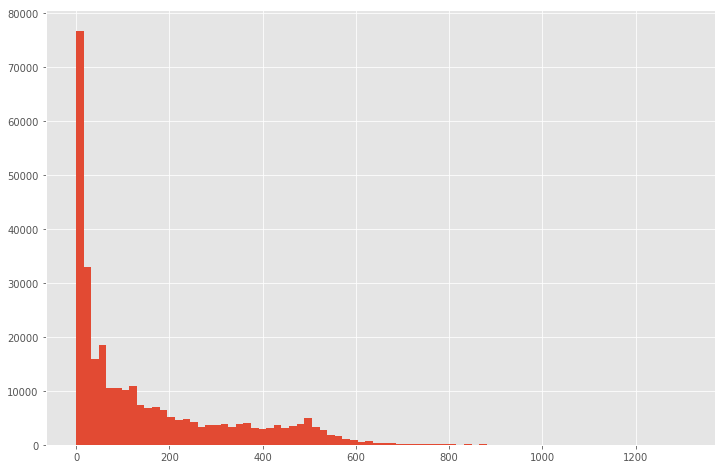

In [25]:
plt.hist(trip_df.DestDwelTime, bins=80); 
# Time people stay in the place they were meant to. It seems like a mixture of an exp distribution and a normal distribution
#  This could be a hint of two types of trips: one which is the "ocassional" trip: shopping, visits, etc and "work related" trip

In [26]:
trip_df.TripPurpGroup.value_counts()

40    155394
30    148699
11     82023
12     28027
50     15228
Name: TripPurpGroup, dtype: int64

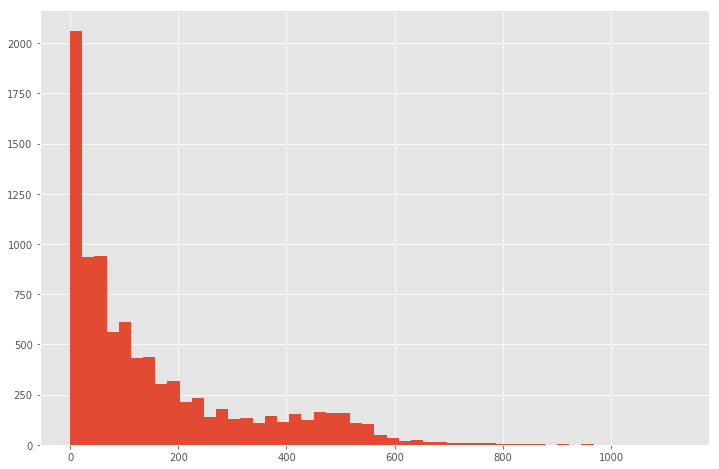

In [27]:
plt.hist(trip_df.DestDwelTime[trip_df.TripPurpGroup==50], bins=50); 

# First model, basic state-space model with activity as the predicted variable

In [279]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;      // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]  beta_hs_a;   // Weights from hidden to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_259edd1f80f0b4efba7afb40cdf624ae NOW.


In [280]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],    # Number of observations (trips)
        'N_I':  len(set(df.SessionId)), # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,# Number of hidden states
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'A':  df['TripPurpGroup'].values}     # Activities

In [281]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [282]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])

In [283]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [284]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [285]:
pred_A = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a), axis=1), axis=1)

In [286]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS 14.406268836648584 % of accuracy
# For 5  HS 8.559373116335141  % of accuracy
# For 10 HS 14.978902953586498 % of accuracy
# For 15 HS 16.75708257986739  % of accuracy

16.75708257986739

# Second model: the hidden state is conditioned on spatio-temporal features too

In [28]:
list_ST = ['HH_1', 'HH_2', 'DDT_wd', 'DDT_we']

In [42]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state   
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state   
    beta_hs_a[nhs,:]  ~ normal(0., 5.); // Weights from hidden to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + ST[t+1,:]*beta_st_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3465a83e14d7e5a0f7444f6d497c16a NOW.


In [43]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [44]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [45]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])

In [46]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [47]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [48]:
pred_A = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a), axis=1), axis=1)

In [49]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS  39.96383363471971 % of accuracy
# For 5  HS  42.07353827606992 % of accuracy
# For 10 HS  40.83107497741644 % of accuracy
# For 15 HS  27.40138512496236 % of accuracy

# The prediction capacity of this model is extremely low, this means that adding complexity to the way the hidden state is defined is not
# the way to go 

27.40138512496236

# Third model, spatio-temporal features affecting the activity directly

In [ ]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  int<lower = 0> N_ST; // Number of spatio-temporal features
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  matrix[N_ST, N_A]   beta_st_a;  // Weights from spatio-temporal to activities
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  for (na in 1:N_A){
    beta_st_a[:,na]  ~ normal(0., 5.);  // Weights from spatio-temporal to activities
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a  + ST[t,:]*beta_st_a + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc835eb9bb990d5572eac4b3145d670a NOW.


In [ ]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'ST': df[list_ST],                  # Spatio-temporal features
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [ ]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [ ]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])

In [ ]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [ ]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [ ]:
pred_A = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a), axis=1), axis=1)

In [ ]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS % of accuracy
# For 5  HS % of accuracy
# For 10 HS % of accuracy
# For 15 HS % of accuracy

# Fourth model, include hidden state as a function of past activity

In [109]:
A_oh = pd.get_dummies(df, columns=['TripPurpGroup'], prefix='A', drop_first=True)[['A_2', 'A_3', 'A_4', 'A_5']].values

In [159]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Data
  matrix[N, N_A-1] A_oh; // Activities, one hot encoded
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  vector[N_A-1]       beta_a_hs;  // Weights from activities to future hidden states 
  
  vector[N_A]  alpha_a;  // Intercept for activities
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  beta_a_hs ~ normal(0., 5.); // Weights for activities to hidden state
  alpha_a  ~ normal(0., 5.);  // Intercepts for activity
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs + A_oh[t,:]*beta_a_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a + alpha_a')');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7387a4a01f98ece14d4187e5524a4a20 NOW.


In [160]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
        
        'A_oh': A_oh,                       # One-hot encoded activities
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [161]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [162]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])

In [163]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [164]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]-1 # We have to take 1 because of python indexing
last_hs   = hidden_states[last_trip, :]

In [165]:
pred_A = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a), axis=1), axis=1)

In [166]:
np.sum(last_A == pred_A)*100/len(last_A) 
# For 2  HS % of accuracy
# For 5  HS % of accuracy
# For 10 HS % of accuracy
# For 15 HS % of accuracy

0.175708257986739

# Fifth model: Hierarchical model using an individual specific intercept from hidden state to activity

In [204]:
# define Stan model with hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Response variables
  int  A[N];  // Activities
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hidden;  // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  matrix[N_HS, N_A]   beta_hs_a;  // Weights from hidden to activities
  
  // Hierarchical parameters for activity
  real              alpha_a_mu[N_A];       // Hierarchical prior mean for activity intercept
  real<lower=0>     alpha_a_sigma[N_A];    // Hierarchical prior sigma for activity intercept
  matrix[N_I, N_A]  alpha_a;  // Intercept for activities for each individual
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);
  
  // Alpha distribution for activity 
  for (na in 1:N_A){          
    alpha_a_mu[na]    ~ normal(0,5);
    alpha_a_sigma[na] ~ cauchy(0,5);
    
    // individual parameters (for each class)
    for (i in 1:N_I){        
      alpha_a[i, na]   ~ normal(alpha_a_mu[na], alpha_a_sigma[na]);
    }
  }

  for (nhs in 1:N_HS){
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    beta_hs_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
  }
  
  for (i in 1:N_I){
    // Priors on initial values
    hidden[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hidden[t+1,:] ~ multi_normal_cholesky(hidden[t,:]*beta_hs_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hidden[t,:]*beta_hs_a + alpha_a[i,:])');
    }
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2fe9dec53e9764bab0215b982fc70ac3 NOW.


In [205]:
# Hyperparameter:
HS = 15

# prepare data for Stan model
data = {'N':    df.shape[0],                # Number of observations (trips)
        'N_I':  len(set(df.SessionId)),     # Number of individuals
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_HS': HS,                         # Number of hidden states
        'N_ST': len(list_ST),               # Number of spatio-temporal features
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'A':  df['TripPurpGroup'].values}   # Activities

In [206]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [207]:
# In order to evaluate the model we need to extract the last hidden state per person and the betas from hidden state to activity
hidden_states = pystan_utils.vb_extract_variable(fit, "hidden", var_type="matrix", dims=[-1, HS])
beta_hs_a = pystan_utils.vb_extract_variable(fit, "beta_hs_a", var_type="matrix", dims=[HS, len(set(df.TripPurpGroup))])

In [208]:
# In order to evaluate the model we have to:
# 1) extract the hidden states and activities corresponding to the last state of each person
# 2) do a dot product between the betas and the hidden state
# 3) do a softmax of the probabilities
# 4) extract the activity with the highest probability and compare with the actual activity

In [209]:
last_trip = trip_idx-1
last_A    = df['TripPurpGroup'].values[last_trip]
last_hs   = hidden_states[last_trip, :]

In [210]:
pred_A = np.argmax(scipy.special.softmax(np.dot(last_hs, beta_hs_a), axis=1), axis=1)

In [211]:
np.sum(last_A == pred_A)/len(last_A) 
# For 2  HS % of accuracy
# For 5  HS % of accuracy
# For 10 HS % of accuracy
# For 15 HS % of accuracy

0.08047016274864376

# Sixth model: Add mode choice as a second predicted variable, using model 3 as a base.
First add it by itself and maybe in model 7 we add it as a function of both hidden state and activity

In [ ]:
pystan_utils.vb_plot_variables(fit, 'beta_hs_a');

In [121]:
list_ST = ['OrigMuncode', 'DiaryMonth', 'DiaryWeekday', 'DiaryDaytype', 'HH_1', 'HH_2']
list_SE = ['HomeAdrMunCode', 'RespSex', 'RespAgeCorrect', 'RespMainOccup', 'RespEdulevel', 'PrimOccMuncode', 'RespHasBicycle', 'RespHasSeasonticket', 'HousehCarOwnership', 'IncRespondent2000', 'kids']

In [ ]:
# define Stan model without hierarchical priors
model_definition = """
data {
  // Sizes
  int<lower = 0> N;    // Number of observations
  int<lower = 0> N_I;  // Number of individuals
  int<lower = 0> N_ST; // Number of spatio-temporal features
  int<lower = 0> N_SE; // Number of socioeconomic features
  int<lower = 0> N_MC; // Number of mode choices
  int<lower = 0> N_A;  // Number of activities
  int<lower = 0> N_L;  // Number of locations
  int<lower = 0> N_HS; // Number of hidden states
  
  // Indexes 
  int<lower = 0> trip_idx[N_I+1]; // Indexes of trips by individual,i.e., the cumulative sum of trips
  
  // Features
  matrix[N, N_ST]   ST;    // Spatio-temporal features
  matrix[N_I, N_SE] SE;  // Socioeconomic features
  
  // Response variables
  int  A[N];  // Activities
  int  MC[N]; // Mode choices
  int  L[N];  // Locations
}
parameters{
  // Hidden state
  matrix[N, N_HS]            hs;      // Hidden states
  vector<lower=0>[N_HS]      tau;     // Cholesky factor premultiplier
  cholesky_factor_corr[N_HS] L_omega; // Cholesky correlation factor
  
  // Global parameters
  matrix[N_SE, N_HS]  beta_se_hs; // Weights from socio-economic to hidden state
  matrix[N_ST, N_HS]  beta_st_hs; // Weights from spatio-temporal to hidden state
  matrix[N_HS, N_HS]  beta_hs_hs; // Weights from hidden state to hidden state
  
  matrix[N_HS, N_A]  beta_a;  // Weights from hidden to activities
  matrix[N_HS, N_MC] beta_mc; // Weights from hidden to mode choice
  matrix[N_HS, N_L]  beta_l;  // Weights from hidden to locations
  
  vector[N_A]  alpha_a;  // Intercept for activities
  vector[N_MC] alpha_mc; // Intercept for mode choice
  vector[N_L]  alpha_l; // Intercept for locations
}
transformed parameters {
  matrix[N_HS, N_HS] L_sigma;
  
  L_sigma = diag_pre_multiply(tau, L_omega); // Cholesky factor pre-multiplication
}
model{
  // Draw globals 
  
  // Hidden state
  vector[N_HS] hs_mu;     // Hidden state prior mean
  tau   ~ cauchy(0., 5.); // Cholesky factor multiplier
  hs_mu = rep_vector(0., N_HS);

  for (nhs in 1:N_HS){
    beta_se_hs[:,nhs] ~ normal(0., 5.); // Weights from socio-economic to hidden state
    beta_st_hs[:,nhs] ~ normal(0., 5.); // Weights from spatio-temporal to hidden state
    beta_hs_hs[:,nhs] ~ normal(0., 5.); // Weights from hidden state to hidden state
    
    beta_a[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to activities
    beta_mc[nhs,:] ~ normal(0., 5.);  // Weights from hidden to mode choice
    beta_l[nhs,:]  ~ normal(0., 5.);  // Weights from hidden to locations
  }
  
  alpha_a  ~ normal(0., 5.); // Intercepts for activity
  alpha_mc ~ normal(0., 5.); // Intercepts for mode choice
  alpha_l  ~ normal(0., 5.); // Intercepts for locations 
  
  for (i in 1:N_I){
    // Priors on initial values
    hs[trip_idx[i]+1,:] ~ multi_normal_cholesky(hs_mu, L_sigma); 
    
    for (t in trip_idx[i]+1:trip_idx[i+1]-1){
      hs[t+1,:] ~ multi_normal_cholesky(hs[t,:]*beta_hs_hs + ST[t,:]*beta_st_hs + SE[i,:]*beta_se_hs, L_sigma);
      
      A[t]  ~ categorical_logit((hs[t,:]*beta_a  + alpha_a')');
      MC[t] ~ categorical_logit((hs[t,:]*beta_mc + alpha_mc')');
      L[t]  ~ categorical_logit((hs[t,:]*beta_l  + alpha_l')');
    }
    A[trip_idx[i+1]]  ~ categorical_logit((hs[trip_idx[i+1]]*beta_a  + alpha_a')');
    MC[trip_idx[i+1]] ~ categorical_logit((hs[trip_idx[i+1]]*beta_mc + alpha_mc')');
    L[trip_idx[i+1]]  ~ categorical_logit((hs[trip_idx[i+1]]*beta_l  + alpha_l')');
  }
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e59c033aee908265b6a2a17945280cc NOW.


In [ ]:
# Hyperparameter:
HS = 20

# prepare data for Stan model
data = {'N': df.shape[0],    # Number of observations (trips)
        'N_I':  len(set(df.SessionId)), # Number of individuals
        'N_ST': len(list_ST),# Number of spatio-temporal features
        'N_SE': len(list_SE),# Number of socioeconomic features
        'N_MC': len(set(df.PrimMode)),# Number of mode choices
        'N_A':  len(set(df.TripPurpGroup)), # Number of activities
        'N_L':  len(set(df.DestMuncode)), # Number of locations
        'N_HS': HS,# Number of hidden states
  
        'trip_idx': np.concatenate(([0], trip_idx.values)),# Indexes of trips by individual,i.e., the cumulative sum of trips
  
        'ST': df[list_ST], # Spatio-temporal features
        'SE': socio_df[list_SE].iloc[pd.Index(np.where(socio_df['SessionId'].isin(list(set(df.SessionId))))[0])], # Socioeconomic features
  
        'N_trips': N_trips['TurNr'].values,  # Number of trips
        'DT': df['DestDwelTime'].values,     # Dwell times
        'A':  df['TripPurpGroup'].values,     # Activities
        'L':  df['DestMuncode'].values,       # Locations
        'MC': df['PrimMode'].values,}        # Mode choices

In [55]:
df.shape

(12514, 23)

In [ ]:
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", elbo_samples=64, grad_samples=1, seed=42, verbose=True)

In [ ]:
import pystan_utils
hidden_states = pystan_utils.vb_extract_variable(fit, "hs", var_type="matrix", dims=[-1, HS])

In [62]:
beta_se_hs = pystan_utils.vb_extract_variable(fit, "beta_se_hs", var_type="matrix", dims=[-1, HS])
beta_st_hs = pystan_utils.vb_extract_variable(fit, "beta_st_hs", var_type="matrix", dims=[-1, HS])
beta_hs_hs = pystan_utils.vb_extract_variable(fit, "beta_hs_hs", var_type="matrix", dims=[HS, HS])

In [67]:
beta_a = pystan_utils.vb_extract_variable(fit, "beta_a", var_type="matrix", dims=[HS, -1])
beta_mc = pystan_utils.vb_extract_variable(fit, "beta_mc", var_type="matrix", dims=[HS, -1])
beta_l = pystan_utils.vb_extract_variable(fit, "beta_l", var_type="matrix", dims=[HS, -1])

In [71]:
alpha_a = pystan_utils.vb_extract_variable(fit, "alpha_a", var_type="vector")
alpha_mc = pystan_utils.vb_extract_variable(fit, "alpha_mc", var_type="vector")
alpha_l = pystan_utils.vb_extract_variable(fit, "alpha_l", var_type="vector")

In [80]:
L_sigma = pystan_utils.vb_extract_variable(fit, "L_sigma", var_type="matrix", dims=[HS, HS])

In [83]:
var_cov = np.dot(L_sigma, L_sigma.T)

In [85]:
np.diag(var_cov)

array([477.14068587,  73.49130064, 219.23393876, 979.11575031,
        51.24476026, 236.94426312,  46.62878435,  59.24398076,
        61.48603124,  21.86311089,  78.82224252,  71.81552422,
       146.02614341, 397.32126919, 216.07309002,  42.55161588,
        35.41882433,  23.67800611,  58.07702268, 116.22600147])

In [88]:
prior_hs = np.random.multivariate_normal(mean=[0.0]*20, cov=var_cov)

In [92]:
socio_df = socio_df[list_SE].iloc[pd.Index(np.where(socio_df['SessionId'].isin(list(set(df.SessionId))))[0])]

In [93]:
socio_df.iloc[0]

HomeAdrMunCode         573
RespSex                  1
RespAgeCorrect          51
RespMainOccup           30
RespEdulevel            11
PrimOccMuncode         561
RespHasBicycle           1
RespHasSeasonticket      2
HousehCarOwnership       2
IncRespondent2000      482
kids                     1
Name: 15572, dtype: int64